Source : [https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb)


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Get the Data

### Download the Data


In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

### Take a Quick Look at the Data Structure


In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


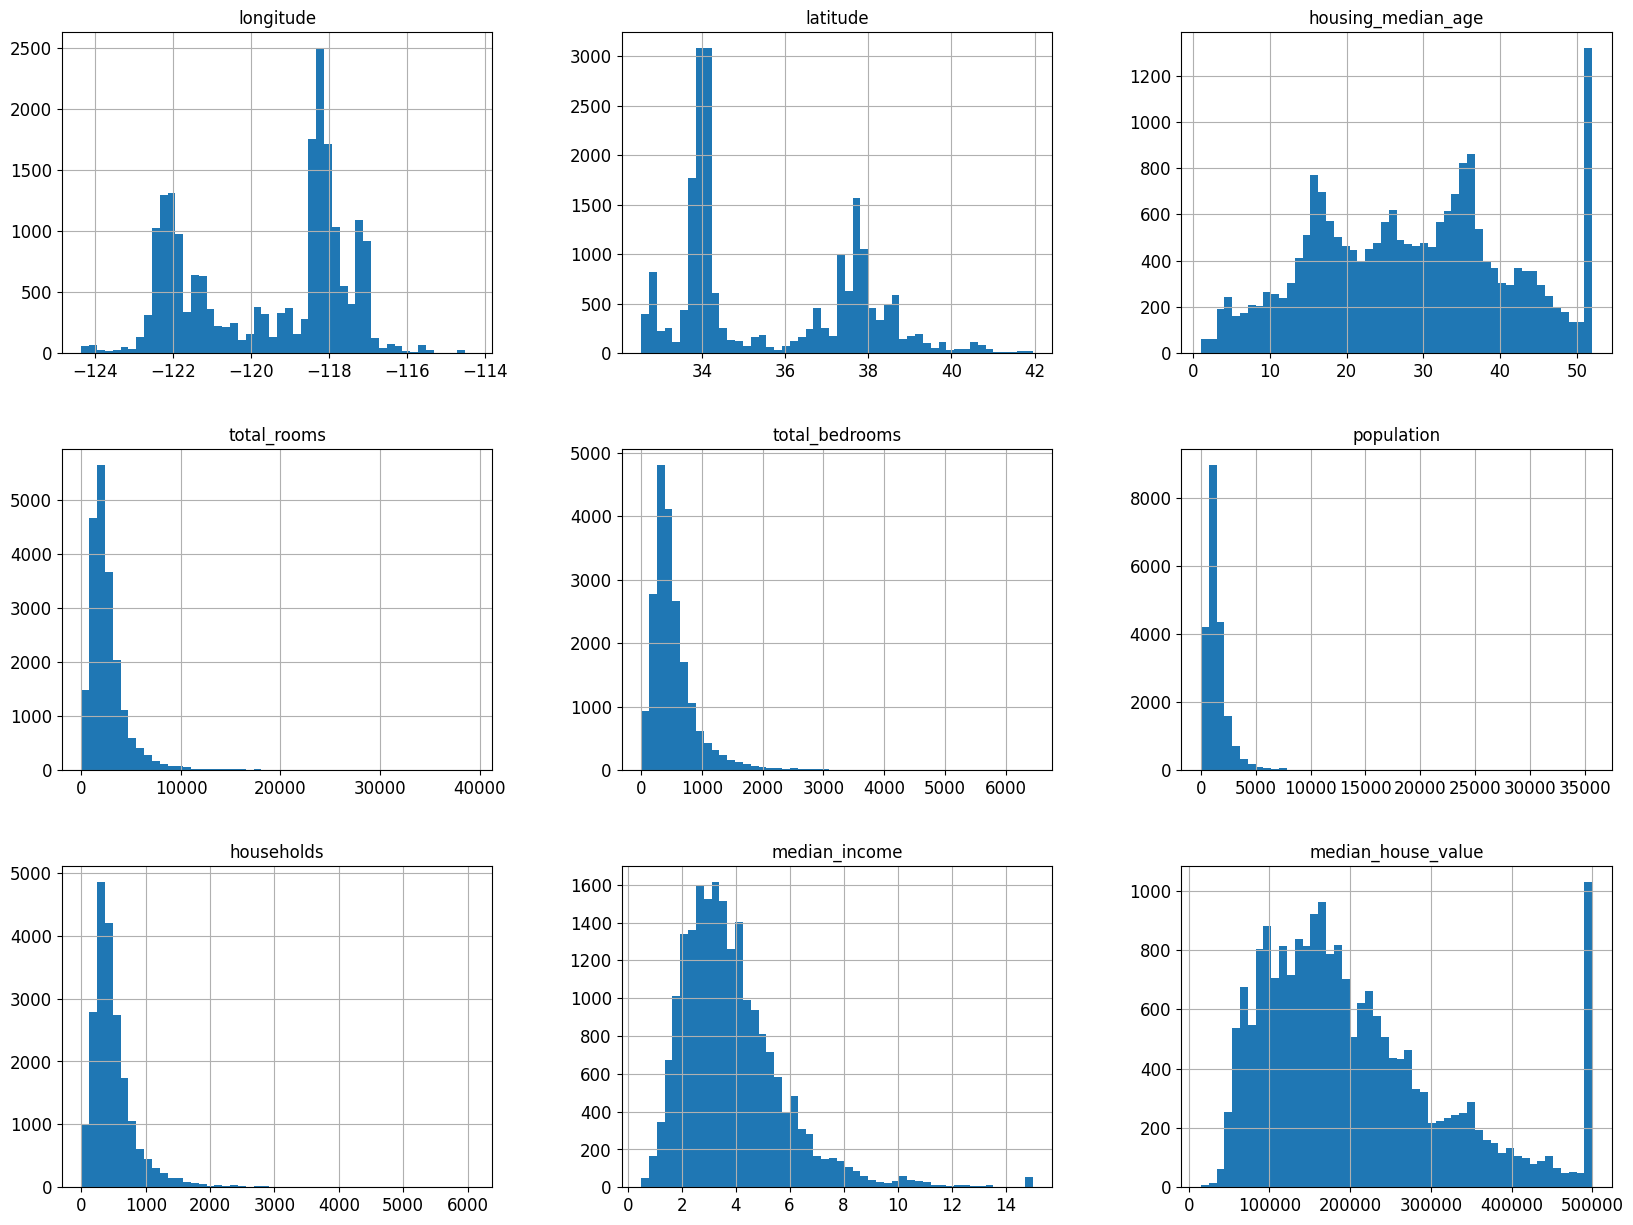

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
# save_fig("attribute_histogram_plots")
plt.show()

### Creating a Test Set


In [10]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [11]:
import numpy as np


# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [13]:
len(test_set)

4128

In [14]:
from zlib import crc32


# 파이썬 2와의 호환성을 위한 비트 연산 (중요하지 않음)
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xFFFFFFFF < test_ratio * 2**32


# 각 샘플의 식별자의 해시값을 계산하여 데이터셋이 갱신되더라도 테스트 세트가 동일하게 유지된다
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
import hashlib


def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [16]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [17]:
housing_with_id = housing.reset_index()  # 행의 인덱스를 식별자로 사용
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [18]:
housing_with_id["id"] = (
    housing["longitude"] * 1000 + housing["latitude"]
)  # 위도와 경도는 변하지 않으므로 ID로 사용
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [19]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [20]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(
    housing, test_size=0.2, random_state=42
)  # 난수 초깃값(random_state)을 지정

In [21]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<Axes: >

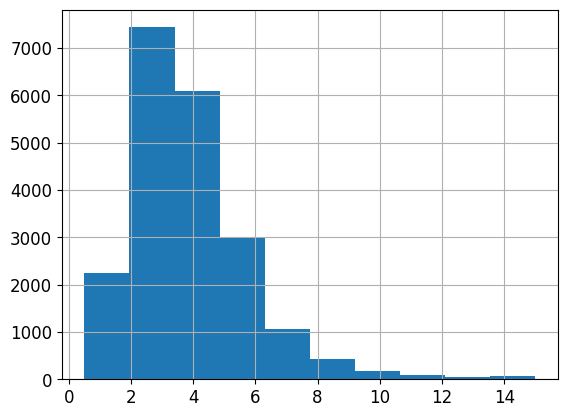

In [22]:
housing["median_income"].hist()

In [23]:
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)

In [24]:
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

<Axes: >

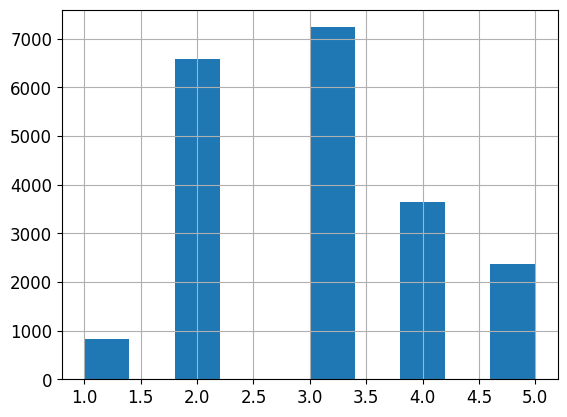

In [25]:
housing["income_cat"].hist()

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [27]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [28]:
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [29]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame(
    {
        "Overall": income_cat_proportions(housing),
        "Stratified": income_cat_proportions(strat_test_set),
        "Random": income_cat_proportions(test_set),
    }
).sort_index()
compare_props["Rand. %error"] = (
    100 * compare_props["Random"] / compare_props["Overall"] - 100
)
compare_props["Strat. %error"] = (
    100 * compare_props["Stratified"] / compare_props["Overall"] - 100
)

In [30]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [31]:
# 계층적 샘플링을 위해 생성했던 소득 카테고리 열 제거
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights


In [32]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

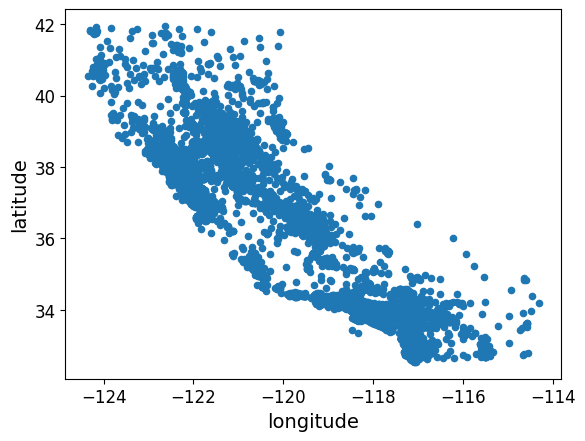

In [33]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

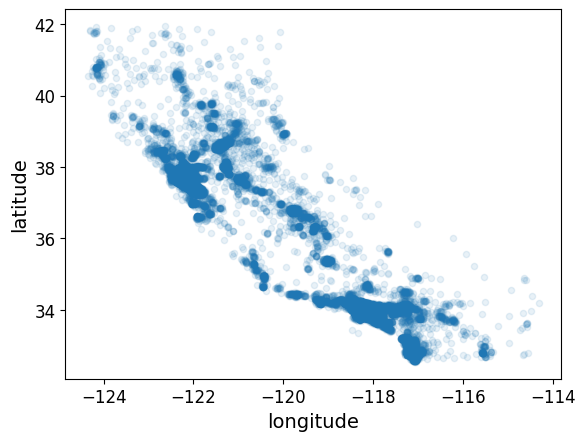

In [34]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

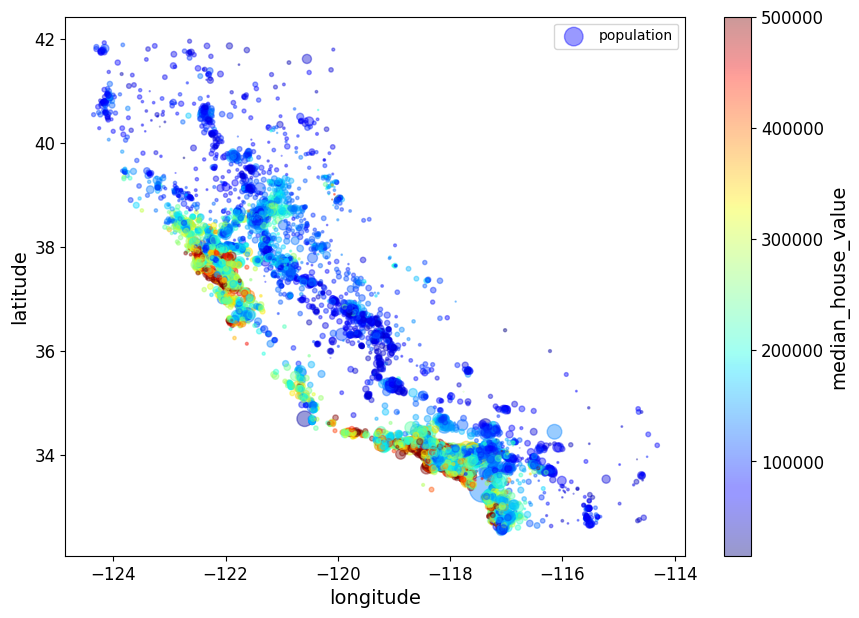

In [35]:
housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    s=housing["population"] / 100,
    label="population",
    figsize=(10, 7),
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    sharex=False,
)
plt.legend()
# save_fig("housing_prices_scatterplot")

In [36]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x1e37665d1d0>)

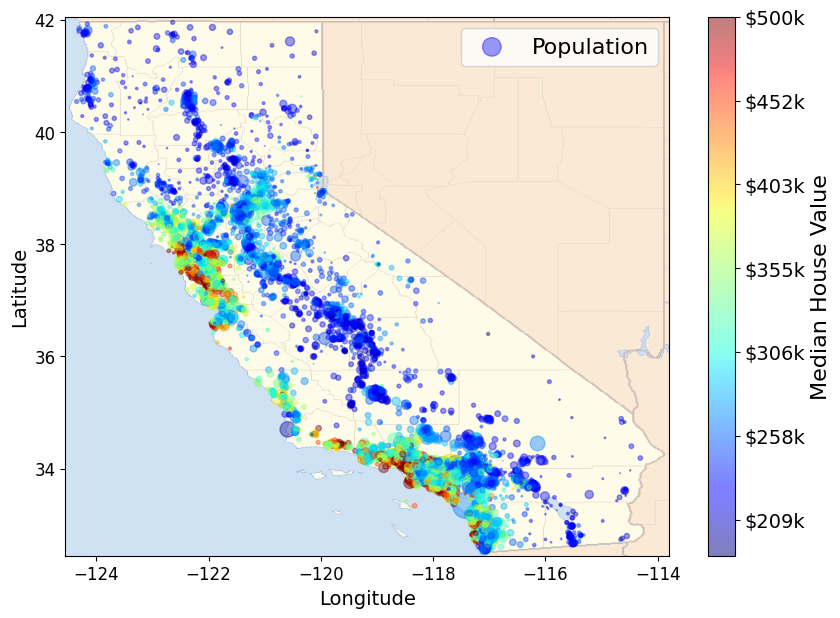

In [37]:
import matplotlib.image as mpimg

california_img = mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    figsize=(10, 7),
    s=housing["population"] / 100,
    label="Population",
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=False,
    alpha=0.4,
)
plt.imshow(
    california_img,
    extent=[-124.55, -113.80, 32.45, 42.05],
    alpha=0.5,
    cmap=plt.get_cmap("jet"),
)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values / prices.max())
cbar.ax.set_yticklabels(["$%dk" % (round(v / 1000)) for v in tick_values], fontsize=14)
cbar.set_label("Median House Value", fontsize=16)

plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()

### Correlation


In [38]:
corr_matrix = housing.corr(numeric_only=True)

In [39]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

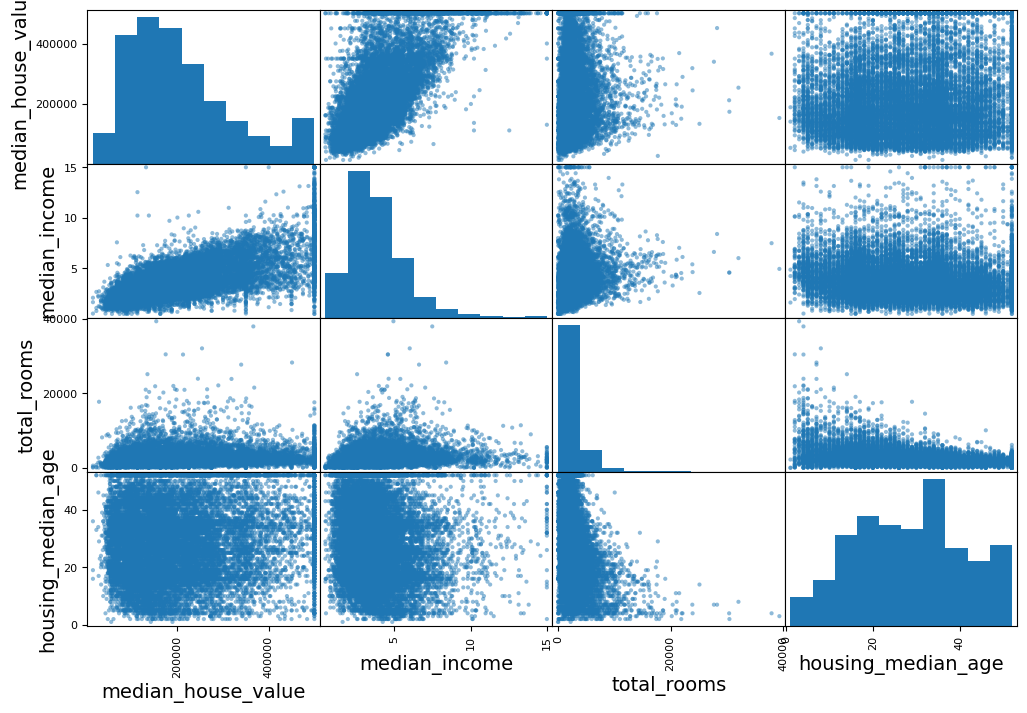

In [40]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = [
    "median_house_value",
    "median_income",
    "total_rooms",
    "housing_median_age",
]
scatter_matrix(housing[attributes], figsize=(12, 8))
# save_fig("scatter_matrix_plot")

(0.0, 16.0, 0.0, 550000.0)

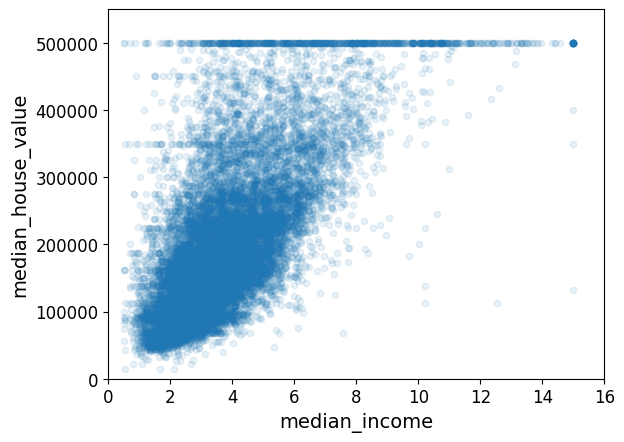

In [41]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0, 16, 0, 550000])
# save_fig("income_vs_house_value_scatterplot")

### Experimenting with Attribute Combinations


In [42]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [43]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms


In [44]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [45]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN


In [46]:
housing_labels

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
           ...   
15174    268500.0
12661     90400.0
19263    140400.0
19140    258100.0
19773     62700.0
Name: median_house_value, Length: 16512, dtype: float64

### Data Cleaning


3 Ways to clean the data

```python
1. housing.dropna(subset=["total_bedrooms"])
2. housing.drop("total_bedrooms", axis=1)
3. median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)
```

Option 1 is deleting the data which has no value in "total_bedrooms".  
Option 2 is deleting whole row (total_bedrooms)  
Option 3 is inserting median value in the data which has no value in "total_bedrooms".


In [47]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [48]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [49]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [50]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [51]:
X = imputer.transform(housing_num)

In [52]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

### Handling Text and Categorical Attributes


In [53]:
housing_cat = housing[["ocean_proximity"]]

In [54]:
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [55]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [56]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [57]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [58]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Custom Transformers


In [59]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[
                X, rooms_per_household, population_per_household, bedrooms_per_room
            ]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [60]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names
]  # get the column indices

In [61]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns) + ["rooms_per_household", "population_per_household"],
    index=housing.index,
)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


### Transformation Pipelines


In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("attribs_adder", CombinedAttributesAdder()),
        ("std_scaler", StandardScaler()),
    ]
)

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [65]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer(
    [("num", num_pipeline, num_attribs), ("cat", OneHotEncoder(), cat_attribs)]
)

housing_prepared = full_pipeline.fit_transform(housing)